In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import xpress  as xp
import networkx as nx

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/andrea/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [2]:
# input
L = 4

custom_setup = False
if custom_setup:
    C = 8
else:
    C = 20 # change this input for other runs

map_size = 100
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [3]:
# define the locations of customers and lockers and warehouse
if custom_setup:
    C_location = 100*np.array([[0.1 ,0.28], [0.2 ,0.4],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],[0.7 ,0.4],[0.9 ,0.5], [0.4, 0.15]])
    W_location = 100*np.array([[0.6 ,0.5]])
    L_location = 100*np.array([[0.3 ,0.5],[0.5,0.2]])
else:
    C_location = np.random.randint(map_size, size=(C, 2))
    W_location = np.random.randint(map_size, size=(1, 2))
    L_location = np.random.randint(map_size, size=(L, 2))
stores_location = np.concatenate((W_location, L_location), axis=0)

In [4]:
def euclidean_distance(location_a, location_b):
    if len(location_a) != 2 or len(location_b) != 2:
        raise Exception("the two location need to be a list each of size 2")
    delta_x = location_b[0]-location_a[0]
    delta_y = location_b[1]-location_a[1]
    return math.sqrt(delta_x*delta_x+delta_y*delta_y)

def find_nearest_stores_from_customer(customer_location, stores_location_par):
    min_distance = float("inf")
    nearest_store_location = []
    index = 0
    nearest_locker_index = -1
    for store_location in stores_location_par:
        distance = euclidean_distance(customer_location, store_location)
        if distance < min_distance:
            min_distance = distance
            nearest_store_location = store_location
            nearest_locker_index = index
        index +=1
    return nearest_locker_index, nearest_store_location


In [5]:
# Customers’ demand and preferences

# define all the stores: eg. stores = [W, L0, L1, .... , Lx]
warehouse = ["W"]
lockers = []
for l in range(L):
    lockers.append("L"+str(l))
stores = warehouse+lockers

if custom_setup:
    C_L = [0, 5, 7]
    C_D = [1, 2, 3, 4, 6]
    S_k =[1, 2, 6]
    a_k = ["L0", "W", "L1"]
else:
    C_L = []
    C_D = []
    S_k = []
    a_k = []
    for client in range(C):
        if random.random()  <= ratio_locker_customers :
            # locker customer
            C_L.append(client)
            a_k.append(random.choice(stores))
        else:
            # door to door customer
            C_D.append(client)
            if random.random() >= ratio_prime_door_to_door_customer:
                S_k.append(client)



In [6]:
# Capacities

q_c = np.ones(C)
q_CD = np.ones(len(C_D)) # TODO take the value of q_c only in the index of a CD customer
q_CL = np.ones(len(C_L)) # TODO take the value of q_c only in the index of a CL customer
q_SK = np.ones(len(S_k)) # TODO take the value of q_c only in the index of a S_k customer

# PF vehicles capacities
Q = math.ceil(0.5 * len(C_D))
# locker storage (every locker has the same capacity by default)
W_l = []
for i in range(L):
    W_l.append(math.ceil(0.8 * C / L))
# LF vehicles capacities (every LF vehicle has the same capacity by default)
Q_l = []
for i in range(L):
    Q_l.append(math.ceil(0.6 * W_l[i]))

sum_W_l = 0
for i in range(len(W_l)):
    sum_W_l += W_l[i]


# supply vehicles storage
Q_L = math.ceil(0.8 * sum_W_l)

print("Q: ",Q)
print("W_l: ",W_l)
print("Q_l: ",Q_l)
print("Q_L: ",Q_L)
print("sum_W_l: ", sum_W_l)


Q:  6
W_l:  [4, 4, 4, 4]
Q_l:  [3, 3, 3, 3]
Q_L:  13
sum_W_l:  16


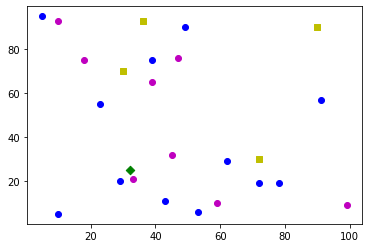

In [7]:
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
S_k_location = np.array([[0,0]])
for i in range(C):
    if i in  C_D:
        CD_location=np.vstack([CD_location, C_location[i]])
    else:
        CL_location = np.vstack([CL_location, C_location[i]])
for i in range(C):
    if i in S_k:
        S_k_location=np.vstack([S_k_location,C_location[i]])

S_k_location=np.delete(S_k_location,0,0)
CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)

#define indexes for the subset S_k
S_k_indexes = []
for s in range(len(S_k_location)):
    S_k_indexes.append("Sk"+str(s))


#define all customers
Customers = []
Customers_door = []
Customers_locker = []
for c in range(len(C_D)):
    Customers_door.append("Cd"+str(c))
for c in range(len(C_L)):
    Customers_locker.append("Cl"+str(c))

Customers = Customers_door+Customers_locker


plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

#piccola nota
#come nel paper in verde è la warehouse, in giallo i locker, mentre in blu in customer door to door e in magenta i customer locker

In [8]:
#calcolo la matrice delle distanze:
all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])
print(all_locations)
all_buildings = stores + Customers

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)




[[32. 25.]
 [30. 70.]
 [36. 93.]
 [72. 30.]
 [90. 90.]
 [39. 75.]
 [10.  5.]
 [53.  6.]
 [78. 19.]
 [23. 55.]
 [ 5. 95.]
 [62. 29.]
 [49. 90.]
 [29. 20.]
 [72. 19.]
 [91. 57.]
 [43. 11.]
 [33. 21.]
 [18. 75.]
 [39. 65.]
 [99.  9.]
 [47. 76.]
 [59. 10.]
 [10. 93.]
 [45. 32.]]
              W         L0          L1         L2          L3        Cd0  \
W      0.000000  45.044423   68.117545  40.311289   87.114867  50.487622   
L0    45.044423   0.000000   23.769729  58.000000   63.245553  10.295630   
L1    68.117545  23.769729    0.000000  72.560320   54.083269  18.248288   
L2    40.311289  58.000000   72.560320   0.000000   62.641839  55.803226   
L3    87.114867  63.245553   54.083269  62.641839    0.000000  53.160135   
Cd0   50.487622  10.295630   18.248288  55.803226   53.160135   0.000000   
Cd1   29.732137  68.007353   91.760558  66.850580  116.726175  75.769387   
Cd2   28.319605  68.007353   88.645361  30.610456   91.787799  70.405966   
Cd3   46.389654  70.035705   85.088190  

In [9]:
#filter data
supply_distances_matrix = dist_matrix.filter(items=stores, axis=1)
supply_distances_matrix = supply_distances_matrix.filter(items=stores, axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=['W'] + Customers_door, axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=['W'] + Customers_door, axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+Customers_door, axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers + Customers_door, axis=0)
print(LF_distances_matrix)

            W         L0         L1         L2         L3
W    0.000000  45.044423  68.117545  40.311289  87.114867
L0  45.044423   0.000000  23.769729  58.000000  63.245553
L1  68.117545  23.769729   0.000000  72.560320  54.083269
L2  40.311289  58.000000  72.560320   0.000000  62.641839
L3  87.114867  63.245553  54.083269  62.641839   0.000000
              W        Cd0        Cd1         Cd2         Cd3        Cd4  \
W      0.000000  50.487622  29.732137   28.319605   46.389654  31.320920   
Cd0   50.487622   0.000000  75.769387   70.405966   68.242216  25.612497   
Cd1   29.732137  75.769387   0.000000   43.011626   69.426220  51.662365   
Cd2   28.319605  70.405966  43.011626    0.000000   28.178006  57.454330   
Cd3   46.389654  68.242216  69.426220   28.178006    0.000000  65.734314   
Cd4   31.320920  25.612497  51.662365   57.454330   65.734314   0.000000   
Cd5   75.026662  39.446166  90.138782  101.118742  105.380264  43.863424   
Cd6   30.265492  51.429563  57.271284   24.6

In [10]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
PF_delivery_cost = PF_delivery_cost.to_numpy()
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)

            W         L0         L1         L2         L3
W    0.000000  33.783317  51.088159  30.233467  65.336150
L0  33.783317   0.000000  17.827296  43.500000  47.434165
L1  51.088159  17.827296   0.000000  54.420240  40.562452
L2  30.233467  43.500000  54.420240   0.000000  46.981379
L3  65.336150  47.434165  40.562452  46.981379   0.000000
[[  0.          50.48762225  29.73213749  28.31960452  46.38965402
   31.32091953  75.02666193  30.2654919   67.18630813   5.83095189
   40.44749683  67.11929678  17.80449381]
 [ 50.48762225   0.          75.76938696  70.40596566  68.24221567
   25.61249695  39.44616585  51.42956348  18.02775638  55.90169944
   65.          55.02726597  64.12487817]
 [ 29.73213749  75.76938696   0.          43.01162634  69.42621983
   51.66236541  90.13878189  57.27128425  93.52005133  24.20743687
   63.56099433  96.25487001  33.54101966]
 [ 28.31960452  70.40596566  43.01162634   0.          28.17800561
   57.45432969 101.11874208  24.69817807  84.09518417  27

In [11]:
LF_delivery_cost_multidim = np.zeros((L,len(C_D)+1,len(C_D)+1))

for i in range(L):
    l = [0]
    l[0]=lockers[i]
    ls = LF_delivery_cost.filter(items=l+Customers_door,axis=1)
    ls = ls.filter(items=l+Customers_door,axis=0)
    print(ls)
    lt = ls.to_numpy()
    for j in range(1+len(C_D)):
        for k in range(1+len(C_D)):
            LF_delivery_cost_multidim[i][j][k]=lt[j][k]



             L0        Cd0        Cd1        Cd2        Cd3        Cd4  \
L0     0.000000   8.751286  57.806250  57.806250  59.530349  14.070004   
Cd0    8.751286   0.000000  64.403979  59.845071  58.005883  21.770622   
Cd1   57.806250  64.403979   0.000000  36.559882  59.012287  43.913011   
Cd2   57.806250  59.845071  36.559882   0.000000  23.951305  48.836180   
Cd3   59.530349  58.005883  59.012287  23.951305   0.000000  55.874167   
Cd4   14.070004  21.770622  43.913011  48.836180  55.874167   0.000000   
Cd5   30.052038  33.529241  76.617965  85.950931  89.573224  37.283911   
Cd6   44.208172  43.715129  48.680592  20.993451  16.037768  39.841342   
Cd7   23.448294  15.323593  79.492044  71.480907  65.190068  37.060390   
Cd8   42.508499  47.516445  20.576321  23.617155  41.658673  30.183978   
Cd9   56.157925  55.250000  54.026845  19.568470   5.100000  51.682516   
Cd10  53.014385  46.773176  81.816640  54.060267  34.137846  57.824995   
Cd11  51.352945  54.506146  28.509867 

In [12]:
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,S_k_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+S_k_indexes)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)

print(compensation_matrix)


distance_matrix_customer_locker_store = dist_matrix.filter(items=Customers_locker,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)
print(distance_matrix_customer_locker_store)


closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
print(closest_store_to_CL)

index_close_locker = []
for i in range(len(closest_store_to_CL)):
    index_close_locker.append(closest_store_to_CL[i])
print(index_close_locker)


# TODO matrix layout to reformat
d_ak_c = compensation_matrix.filter(items = S_k_indexes,axis=1)
d_ak_c=d_ak_c.filter(items=index_close_locker,axis=0)
print(d_ak_c)

ro = 0.5
compensation_matrix_cost = ro*d_ak_c
print(compensation_matrix_cost)
compensation_matrix_cost_multidim = compensation_matrix_cost.to_numpy()
print(compensation_matrix_cost_multidim)


             W         L0         L1         L2          L3        Sk0  \
W     0.000000  45.044423  68.117545  40.311289   87.114867  50.487622   
L0   45.044423   0.000000  23.769729  58.000000   63.245553  10.295630   
L1   68.117545  23.769729   0.000000  72.560320   54.083269  18.248288   
L2   40.311289  58.000000  72.560320   0.000000   62.641839  55.803226   
L3   87.114867  63.245553  54.083269  62.641839    0.000000  53.160135   
Sk0  50.487622  10.295630  18.248288  55.803226   53.160135   0.000000   
Sk1  29.732137  68.007353  91.760558  66.850580  116.726175  75.769387   
Sk2  28.319605  68.007353  88.645361  30.610456   91.787799  70.405966   
Sk3  31.320920  16.552945  40.162171  55.009090   75.591005  25.612497   
Sk4  75.026662  35.355339  31.064449  93.348808   85.146932  39.446166   
Sk5  30.265492  52.009614  69.079664  10.049876   67.119297  51.429563   
Sk6   5.830952  50.009999  73.334848  44.147480   92.849340  55.901699   
Sk7  17.804494  60.415230  82.298238  

In [13]:

def find_closest_Cl_to_locker(i):
    only_cl_close_to_l_i=[]
    counter = 0
    for j in range(len(index_close_locker)):
        if lockers[i] == index_close_locker[j]:
            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)
            counter = counter+1
    #only_cl_close_to_l_i = only_cl_close_to_l_i.astype(int)
    return only_cl_close_to_l_i
def find_q_array_for_closest_cl_to_locker(i):
    q_cl_close_to_locker_i=[]
    only_cl_close_to_l_i=[]
    counter = 0
    for j in range(len(index_close_locker)):
        if lockers[i] == index_close_locker[j]:
            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)
            counter = counter+1

    q_cl_close_to_locker_i = np.ones(counter)
    q_cl_close_to_locker_i=q_cl_close_to_locker_i.astype(int)
    return q_cl_close_to_locker_i

In [14]:
print(len(find_closest_Cl_to_locker(1)))
print(find_q_array_for_closest_cl_to_locker(1))

1
[1]


In [15]:
col_ind = []
d_ak_k=[]
index_close_locker = []
min_value = []
Sk_def=[]
OC = []
position_sk = []
position_cl = []
pck = np.array([])
locker_where_oc_goes=[]
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,CD_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+Customers_door)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)


distance_matrix_customer_locker_store = dist_matrix.filter(items=Customers_locker,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)



closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()


min_value_col = distance_matrix_customer_locker_store.min()
print(min_value_col)

for i in range(len(closest_store_to_CL)):
    index_close_locker.append(closest_store_to_CL[i])
    min_value.append(min_value_col[i])
print(index_close_locker)
print((min_value))


d_ak_c = compensation_matrix.filter(items = index_close_locker,axis=1)
d_ak_c=d_ak_c.filter(items=Customers_door,axis=0)
print(d_ak_c)

for i in range(len(C_L)):
    col_ind.append("D_"+index_close_locker[i]+"_"+Customers_locker[i])
print(col_ind)

d_ak_k = pd.DataFrame(min_value, index=col_ind)
print(d_ak_k)

d_c_k = dist_matrix.filter(items=Customers_door,axis=0)
d_c_k = d_c_k.filter(items=Customers_locker,axis=1)
print(d_c_k)
print("=========================")
sum_dck_dakc = d_ak_c.to_numpy()+d_c_k.to_numpy()

def find_Sk(cd,cl):
    S_K_i = []
    if sum_dck_dakc[cl][cd]<=1.5*d_ak_k.to_numpy()[cl]:
        S_K_i.append('Cd'+str(cd))
    return S_K_i
print(find_Sk(0,0))

for cl in range(len(C_L)):
    for cd in range(len(C_D)):
        if sum_dck_dakc[cd][cl]<=1.5*d_ak_k.to_numpy()[cl]:
            OC.append('Cl'+str(cl))
            Sk_def.append('Cd'+str(cd))
            position_sk.append(cd)
            position_cl.append(cl)
            locker_where_oc_goes.append((index_close_locker[cl]))

print(Sk_def)
print(OC)
print(locker_where_oc_goes)
print(position_cl)
print(position_sk)
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

OC_unique = unique(OC)
print(OC_unique)
Sk = unique(Sk_def)
Sk=sorted(Sk, key=lambda x: int("".join([i for i in x if i.isdigit()])))
print(Sk)



index_of_cl_associated_to_closest_locker =[]
for i in range(len(OC_unique)):
    index_of_cl_associated_to_closest_locker.append(OC_unique[i]+'->'+index_close_locker[i])
print(index_of_cl_associated_to_closest_locker)


big_matrix= np.zeros((len(Customers_door),len(Customers_locker)))
big_matrix=pd.DataFrame(big_matrix, index=Customers_door, columns=Customers_locker)
for i in range(len(position_sk)):
    big_matrix.values[position_sk[i]][position_cl[i]]=d_ak_c.values[position_sk[i]][position_cl[i]]

d_cd_oc=big_matrix.filter(items=OC_unique,axis=1)
d_ak_c=d_cd_oc.filter(items=Sk,axis=0)
d_ak_c.columns= index_of_cl_associated_to_closest_locker
print(d_ak_c)



d_ak_c = d_ak_c.to_numpy()
pck = 0.5*d_ak_c
for c in range(len(Sk)):
    for k in range(len(OC_unique)):
        if pck[c][k]==0:
            pck[c][k]=100000
print(pck)




Cl0     4.123106
Cl1    13.000000
Cl2    10.295630
Cl3    34.205263
Cl4    18.027756
Cl5    23.853721
Cl6    26.000000
Cl7    14.764823
dtype: float64
['W', 'L0', 'L0', 'L2', 'L0', 'L2', 'L1', 'W']
[4.123105625617661, 13.0, 10.295630140987, 34.20526275297414, 18.027756377319946, 23.853720883753127, 26.0, 14.7648230602334]
              W         L0         L0         L2         L0         L2  \
Cd0   50.487622  10.295630  10.295630  55.803226  10.295630  55.803226   
Cd1   29.732137  68.007353  68.007353  66.850580  68.007353  66.850580   
Cd2   28.319605  68.007353  68.007353  30.610456  68.007353  30.610456   
Cd3   46.389654  70.035705  70.035705  12.529964  70.035705  12.529964   
Cd4   31.320920  16.552945  16.552945  55.009090  16.552945  55.009090   
Cd5   75.026662  35.355339  35.355339  93.348808  35.355339  93.348808   
Cd6   30.265492  52.009614  52.009614  10.049876  52.009614  10.049876   
Cd7   67.186308  27.586228  27.586228  64.257295  27.586228  64.257295   
Cd8    5.8

In [362]:
# Xpress formulation
single_period_problem = xp.problem()

In [363]:
# var definition
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)
x_i_j = np.array([[xp.var(name="x_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_PF)]for j in range(J_PF)], dtype=xp.npvar)
y_i_j = np.array([[xp.var(name="y_"+str(i)+"_"+str(j), vartype=xp.integer,lb=0) for i in range(I_PF)]for j in range(J_PF)], dtype=xp.npvar)

I_L = 1 + L
J_L = 1 + L
x_i_j_L = np.array([[xp.var(name="x_L_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_L)]for j in range(J_L)], dtype=xp.npvar)
y_i_j_L = np.array([[xp.var(name="y_L_"+str(i)+"_"+str(j), vartype=xp.integer,lb=0) for i in range(I_L)]for j in range(J_L)], dtype=xp.npvar)

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)
x_l_i_j = np.array([[[xp.var(name="x_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_LF)]for j in range(J_LF)] for l in range(L)], dtype=xp.npvar)
y_l_i_j = np.array([[[xp.var(name="y_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.integer,lb=0) for i in range(I_LF)]for j in range(J_LF)] for l in range(L)], dtype=xp.npvar)

z_c = np.array([xp.var(name="z_c"+str(c), vartype=xp.binary) for c in range(len(C_D))], dtype=xp.npvar)
z_c_l = np.array([[xp.var(name="z_c"+str(c)+"_l"+str(l), vartype=xp.binary) for c in range(len(C_D))]for l in range(L)], dtype=xp.npvar)
z_l_L = np.array([[xp.var(name="z_l_L_"+str(l), vartype=xp.binary) for l in range(L)]], dtype=xp.npvar)

w_c_k = np.array([[xp.var(name="w_"+str(Sk[cd])+"_"+str(OC_unique[oc]), vartype=xp.binary)for oc in range(len(OC_unique)) ]for cd in range(len(Sk))], dtype=xp.npvar)

# add var to the problem
single_period_problem.addVariable(x_i_j)
single_period_problem.addVariable(x_i_j_L)
single_period_problem.addVariable(x_l_i_j)

single_period_problem.addVariable(y_i_j)
single_period_problem.addVariable(y_i_j_L)
single_period_problem.addVariable(y_l_i_j)

single_period_problem.addVariable(z_c)
single_period_problem.addVariable(z_c_l)
single_period_problem.addVariable(z_l_L)

single_period_problem.addVariable(w_c_k)


In [364]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstraint( xp.Sum( w_c_k[s][k]for s in range(len(Sk)) for k in range(len(OC_unique))if Customers_door[c] == Sk[s])
                                         + xp.Sum(z_c_l[l][c] for l in range(L))+z_c[c] == 1)

# constraint eq. 3
for c_l in range(len(OC_unique)):
    single_period_problem.addConstraint( xp.Sum(w_c_k[s_k][c_l] for s_k in range(len(Sk))) <= 1)


# constraint eq. 4
for l in range(L):
    single_period_problem.addConstraint(
        xp.Sum(find_q_array_for_closest_cl_to_locker(l)[cl]+ xp.Sum(w_c_k[sk][cl]
        for sk in range(len(Sk))) for cl in range(len(find_closest_Cl_to_locker(l))))
        + xp.Sum(q_CD[cd]*z_c_l[l][cd] for cd in range(len(C_D)))
        <= W_l[l] * z_l_L[0][l]
    )

# Professional fleet constraint

# constraint eq. 5.1 A == C
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[i+1][j] for j in range(len(C_D)+1))
        == z_c[i]
    )


# constraint eq. 5.2 B == C
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[j][i+1] for j in range(len(C_D)+1))
        == z_c[i]
    )



# constraint eq. 6
single_period_problem.addConstraint(
    xp.Sum( x_i_j[0][j+1] for j in range(len(C_D)))
    - xp.Sum( x_i_j[j+1][0] for j in range(len(C_D)))
    == 0
)

# constraint eq. 7
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( y_i_j[j][i+1] for j in range(1+len(C_D)))
        - xp.Sum( y_i_j[i+1][j] for j in range(1+len(C_D)))
        == q_CD[i]*z_c[i]
    )

# constraint eq. 8
single_period_problem.addConstraint(
    xp.Sum( y_i_j[j+1][0] for j in range(len(C_D)))
    - xp.Sum( y_i_j[0][j+1] for j in range(len(C_D)))
    == - xp.Sum( q_CD[i]*z_c[i] for i in range(len(C_D)))
)

# constraint eq. 9
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        single_period_problem.addConstraint(
            y_i_j[i][j]
            <= Q * x_i_j[i][j]
        )

# constraint eq. 10
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        y_i_j[i+1][0]
        == 0
    )

# Supply routes constraints

# constraint eq. 11.1 A == C
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j_L[i+1][j] for j in range(1 + L))
        == z_l_L[0][i]
    )

# constraint eq. 11.2 B == C
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j_L[j][i+1] for j in range(1 + L))
        == z_l_L[0][i]
    )



# constraint eq. 12
single_period_problem.addConstraint(
    xp.Sum( x_i_j_L[0][j+1] for j in range(L))
    - xp.Sum( x_i_j_L[j+1][0] for j in range(L))
    == 0
)

# constraint eq. 13
for i in range(L):
    single_period_problem.addConstraint(
        xp.Sum( y_i_j_L[j][i+1] for j in range(1+L))
        - xp.Sum( y_i_j_L[i+1][j] for j in range(1+L))
        ==
        xp.Sum(find_q_array_for_closest_cl_to_locker(i)[cl] + xp.Sum(w_c_k[sk][cl]
        for sk in range(len(Sk))) for cl in range(len(find_closest_Cl_to_locker(i))))
        + xp.Sum(q_CD[c]*z_c_l[i][c] for c in range(len(C_D)))
    )

# constraint eq. 14
single_period_problem.addConstraint(
    xp.Sum( y_i_j_L[j+1][0] for j in range(L))
    - xp.Sum( y_i_j_L[0][j+1] for j in range(L))
    == - xp.Sum(
    xp.Sum(find_q_array_for_closest_cl_to_locker(i)[cl] + xp.Sum(w_c_k[sk][cl]
    for sk in range(len(Sk))) for cl in range(len(find_closest_Cl_to_locker(i))))
    + xp.Sum(q_CD[c]*z_c_l[i][c] for c in range(len(C_D)))
    for i in range(L)
    )
)

# constraint eq. 15
for i in range(1 + L):
    for j in range(1 + L):
        single_period_problem.addConstraint(
            y_i_j_L[i][j]
            <= Q_L * x_i_j_L[i][j]
        )

# constraint eq. 16
for i in range(L):
    single_period_problem.addConstraint(
        y_i_j_L[i+1][0]
        == 0
    )

# Local fleet constraints
for l in range(L):
    # constraint eq. 17.1 A == C
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( x_l_i_j[l][i+1][j] for j in range(len(C_D)+1))
            == z_c_l[l][i]
        )


    # constraint eq. 17.2 B == C
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( x_l_i_j[l][j][i+1] for j in range(len(C_D)+1))
            == z_c_l[l][i]
        )


    # constraint eq. 18
    single_period_problem.addConstraint(
        xp.Sum( x_l_i_j[l][0][j+1] for j in range(len(C_D)))
        - xp.Sum( x_l_i_j[l][j+1][0] for j in range(len(C_D)))
        == 0
    )

    # constraint eq. 19
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            xp.Sum( y_l_i_j[l][j][i+1] for j in range(1+len(C_D)))
            - xp.Sum( y_l_i_j[l][i+1][j] for j in range(1+len(C_D)))
            == q_CD[i]*z_c_l[l][i]
        )

    # constraint eq. 20
    single_period_problem.addConstraint(
        xp.Sum( y_l_i_j[l][j+1][0] for j in range(len(C_D)))
        - xp.Sum( y_l_i_j[l][0][j+1] for j in range(len(C_D)))
        == - xp.Sum( q_CD[i]*z_c_l[l][i] for i in range(len(C_D)))
    )

    # constraint eq. 21
    for i in range(1 + len(C_D)):
        for j in range(1 + len(C_D)):
            single_period_problem.addConstraint(
                y_l_i_j[l][i][j]
                <= Q_l[l] * x_l_i_j[l][i][j]
            )

    # constraint eq. 22
    for i in range(len(C_D)):
        single_period_problem.addConstraint(
            y_l_i_j[l][i+1][0]
            == 0
        )
for i in range(len(C_D)+1):
    single_period_problem.addConstraint(x_i_j[i][i]==0)

for i in range(L+1):
    single_period_problem.addConstraint(x_i_j_L[i][i]==0)

for l in range(L):
    for i in range(len(C_D)+1):
        single_period_problem.addConstraint(x_l_i_j[l][i][i]==0)

In [365]:
single_period_problem.setObjective(
    xp.Sum( xp.Sum(supply_cost.values[i][j]*x_i_j_L[i][j]   for j in range(1+L) )  for i in range(1+L))+
    xp.Sum( xp.Sum(pck[c][k] *w_c_k[c][k]  for k in range(len(OC_unique))) for c in range(len(Sk)))+
    xp.Sum( xp.Sum(PF_delivery_cost[i][j]*x_i_j[i][j] for j in range(1+len(C_D) ) )for i in range(1+len(C_D))) +
    xp.Sum( xp.Sum(xp.Sum(LF_delivery_cost_multidim[l][i][j]*x_l_i_j[l][i][j] for j in range(1+len(C_D)))for i in range(1+len(C_D)))for l in range(L))
    ,sense=xp.minimize
    )   #sense=minimise is the default value

In [366]:
single_period_problem.solve()

x_i_j_sol = single_period_problem.getSolution(x_i_j)
print("\n\n Solution:\n",x_i_j_sol, "\n")
x_i_j_L_sol = single_period_problem.getSolution(x_i_j_L)
print("\n\n Solution:\n",x_i_j_L_sol, "\n")
x_l_i_j_sol = single_period_problem.getSolution(x_l_i_j)
print("\n\n Solution:\n",x_l_i_j_sol, "\n")
w_c_k_sol = single_period_problem.getSolution(w_c_k)
print("\n\n Solution:\n",w_c_k_sol, "\n")

FICO Xpress v8.13.5, Community, solve started 16:20:26, Jun 10, 2022
Heap usage: 1172KB (peak 1172KB, 1024KB system)
Minimizing MILP noname using up to 4 threads, with these control settings:
OUTPUTLOG = 1
Original problem has:
      1229 rows         1829 cols         5783 elements      1829 globals
Presolved problem has:
       718 rows         1209 cols         3831 elements      1209 globals
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 1649KB (peak 2489KB, 1024KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.30e+01] / [ 1.25e-01,  1.62e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  6.00e+00] / [ 1.00e+00,  1.30e+01]
  Objective      [min,max] : [ 3.00e+00,  1.00e+05] / [ 1.05e-05,  1.00e+05]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 4.5GB
 *** Solution found:  101829.0825   Time:   0    Heuristic: e ***
 *** Solution found: 

In [367]:
print("Solve status: ", single_period_problem.getProbStatus())

Solve status:  6


In [368]:
single_period_problem.write("problem.lp")

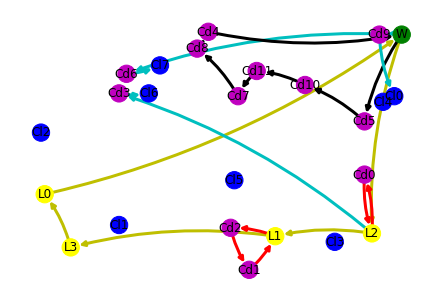

In [369]:
#plot
G = nx.DiGraph()
nodes_name = stores+Customers
pf_names =['W']+Customers_door
def lfnames(l):
   lf_names =['L'+str(l)]+Customers_door
   return lf_names

def shape_node():
    if nodes_name[i] == 'W':
        shape='d'
    for l in range(L):
        if nodes_name[i]==lockers[l]:
            shape='s'
    for c in range(len(Customers_door)):
        if nodes_name[i]==Customers_door[c]:
            shape='o'
    for cl in range(len(Customers_locker)):
        if nodes_name[i]==Customers_locker[cl]:
            shape='o'
    return shape


for x in range(len(all_locations)):
        G.add_node(nodes_name[x],pos=(all_locations[x,0],all_locations[x,1]))


color_map = []
for i in range(len(nodes_name)):
    if nodes_name[i] == 'W':
        color_map.append('green')
    for l in range(L):
        if nodes_name[i]==lockers[l]:
            color_map.append('yellow')
    for c in range(len(Customers_door)):
        if nodes_name[i]==Customers_door[c]:
            color_map.append('m')
    for cl in range(len(Customers_locker)):
        if nodes_name[i]==Customers_locker[cl]:
            color_map.append('blue')





for x in range(L+1):
    for y in range(1+L):
        x_i_j_L_sol=np.round(x_i_j_L_sol)
        if x_i_j_L_sol[x][y]==1:
             G.add_edge(stores[x],stores[y],color='y',weight=3)

for x in range(1+len(C_D)):
    for y in range(1+len(C_D)):
       x_i_j_sol=np.round_(x_i_j_sol)
       if x_i_j_sol[x][y]==1:
         G.add_edge(pf_names[x],pf_names[y],color='k',weight=3)

for l in range(L):
    for x in range(1+len(C_D)):
        for y in range(1+len(C_D)):
            x_l_i_j_sol[l]=np.round_(x_l_i_j_sol[l])
            if x_l_i_j_sol[l][x][y]==1:
                G.add_edge(lfnames(l)[x],lfnames(l)[y],color='r',weight=3)

for s in range(len(Sk)):
    for k in range(len(OC_unique)):
        w_c_k_sol=np.round(w_c_k_sol)
        if w_c_k_sol[s][k]==1:
            G.add_edge(index_close_locker[k],Sk[s],color='c',weight=3)
            G.add_edge(Sk[s],OC_unique[k],color='c',weight=3)



colors = nx.get_edge_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()
pos=nx.get_node_attributes(G,'pos')

nx.draw(G, pos,
        edge_color=colors,
        width=list(weights),
        with_labels=True,
        node_color=color_map,
        arrows = True,
        connectionstyle='arc3,rad=0.1',
        node_shape = shape_node()
        )
